In [1]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Activation, Dropout, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import Adam
from tqdm.keras import TqdmCallback
from keras_tqdm import TQDMCallback
from keras.callbacks import EarlyStopping
from keras.models import load_model
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
import shutil

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
try:
    __IPYTHON__
except NameError:
    # Not in IPython.
    ipython = False
else:
    # In IPython.
    ipython = True

In [3]:
# Add the python path to the folder containing some useful custom packages.
import sys
sys.path.insert(0, "../../packages/")
from TsIP.TsIP import TsIP
from tools import find_multiple_sets
from LagsCreator.LagsCreator import LagsCreator

In [4]:
# Create workspace.
dir = "./output"
if not os.path.exists(dir):
    os.makedirs(dir)
else:
    shutil.rmtree(dir)           
    os.makedirs(dir)

## Dataset

In [5]:
COUNTRY = "Yemen"

In [6]:
PATH_TO_DATA_FOLDER = "../../Dataset time-series/data/" + COUNTRY + "/"

In [7]:
# Load the dataset of the training sets.
train = pd.read_csv(PATH_TO_DATA_FOLDER + "train_smooth.csv", header = [0, 1], index_col = 0)
train.index.name = "Datetime"
train.index = pd.to_datetime(train.index)
freq = "D"
train.index.freq = freq

In [8]:
# Load the dataset of the test sets.
test = pd.read_csv(PATH_TO_DATA_FOLDER + "test_target.csv", header = [0, 1], index_col = 0)
test.index.name = "Datetime"
test.index = pd.to_datetime(test.index)
freq = "D"
test.index.freq = freq

In [9]:
# Load the dataset of the whole time-series of the fcs indicator.
target = pd.read_csv(PATH_TO_DATA_FOLDER + "all_target.csv", header = [0, 1], index_col = 0)
target.index.name = "Datetime"
target.index = pd.to_datetime(target.index)
freq = "D"
target.index.freq = freq

In [10]:
TEST_SIZE = 30
FREQ = train.index.freq

In [11]:
TRAIN = train.copy()

In [12]:
PROVINCES = TRAIN.columns.get_level_values(0).unique()
PROVINCES

Index(['Abyan', 'Aden', 'Al Bayda', 'Al Dhale'e', 'Al Hudaydah', 'Al Jawf',
       'Al Maharah', 'Al Mahwit', 'Amanat Al Asimah', 'Amran', 'Dhamar',
       'Hajjah', 'Ibb', 'Lahj', 'Marib', 'Raymah', 'Sa'ada', 'Sana'a',
       'Shabwah', 'Taizz'],
      dtype='object', name='AdminStrata')

In [13]:
PREDICTORS = TRAIN.columns.get_level_values(1).unique()
PREDICTORS

Index(['1 Month Anomaly (%) Rainfall', '3 Months Anomaly (%) Rainfall',
       'Cereals and tubers', 'Exchange rate (USD/LCU)', 'FCS', 'Fatality',
       'Lat', 'Lon', 'NDVI Anomaly', 'Population', 'Rainfall (mm)', 'Ramadan',
       'rCSI'],
      dtype='object', name='Indicator')

## Data source transformation

I decide to normalize the data among the provinces considering indicator by indicator of the training sets.

In [14]:
global SCALERS

MIN = 0
MAX = 1
SCALERS = dict()
def normalization(group, feature_range):
    min_, max_ = feature_range
    min_group = group.min().min()
    max_group = group.max().max()
    
    # Normalization.
    group_std = (group - min_group) / (max_group - min_group)
    group_scaled = group_std * (max_ - min_) + min_

    # Save the scalers for the various indicators.
    SCALERS[group.name] = (min_group, max_group)

    return group_scaled

In [15]:
TRAIN_NORMALIZED = TRAIN.groupby(axis = 1, level = 1).apply(lambda x: normalization(x, (MIN, MAX)))
TRAIN_NORMALIZED.head()

AdminStrata                        Abyan                                \
Indicator   1 Month Anomaly (%) Rainfall 3 Months Anomaly (%) Rainfall   
Datetime                                                                 
2018-08-22                      0.202614                      0.327464   
2018-08-23                      0.201694                      0.323172   
2018-08-24                      0.200218                      0.317813   
2018-08-25                      0.198491                      0.312132   
2018-08-26                      0.196724                      0.306528   

AdminStrata                                                                 \
Indicator   Cereals and tubers Exchange rate (USD/LCU)       FCS  Fatality   
Datetime                                                                     
2018-08-22            0.109379                0.097113  0.398119  0.016014   
2018-08-23            0.115215                0.108255  0.416745  0.014270   
2018-08-24            0.118301                0.112477  0.422543  0.014297   
2018-08-25            0.119918                0.113002  0.424258  0.015185   
2018-08-26            0.121119                0.112481  0.427209  0.016327   

AdminStrata                                              ...  \
Indicator         Lat       Lon NDVI Anomaly Population  ...   
Datetime                                                 ...   
2018-08-22   0.204339  0.354998     0.203677   0.137715  ...   
2018-08-23   0.204339  0.354998     0.201767   0.137715  ...   
2018-08-24   0.204339  0.354998     0.199870   0.137715  ...   
2018-08-25   0.204339  0.354998     0.197950   0.137715  ...   
2018-08-26   0.204339  0.354998     0.195990   0.137715  ...   

AdminStrata                   Taizz                                        \
Indicator   Exchange rate (USD/LCU)       FCS  Fatality      Lat      Lon   
Datetime                                                                    
2018-08-22                 0.100691  0.521481  0.124455  0.13656  0.07253   
2018-08-23                 0.105181  0.505624  0.118668  0.13656  0.07253   
2018-08-24                 0.109271  0.494372  0.115789  0.13656  0.07253   
2018-08-25                 0.113148  0.486382  0.115893  0.13656  0.07253   
2018-08-26                 0.116965  0.480822  0.118913  0.13656  0.07253   

AdminStrata                                                          
Indicator   NDVI Anomaly Population Rainfall (mm) Ramadan      rCSI  
Datetime                                                             
2018-08-22      0.317287   0.894478      0.430215     0.0  0.522625  
2018-08-23      0.314277   0.894478      0.436639     0.0  0.513277  
2018-08-24      0.311164   0.894478      0.446466     0.0  0.511028  
2018-08-25      0.307901   0.894478      0.458051     0.0  0.511425  
2018-08-26      0.304470   0.894478      0.470108     0.0  0.512072  

[5 rows x 260 columns]

In [16]:
# Plot time-series.
#TsIP(TRAIN_NORMALIZED).interactive_plot_df(title = "Training sets", matplotlib = False, style = "lines")

In [17]:
def denormalization(group_scaled, indicator, feature_range, scalers):
    min_, max_ = feature_range
    min_group, max_group = scalers[indicator]

    group_std = (group_scaled - min_) / (max_ - min_)
    group = (group_std * (max_group - min_group)) + min_group
    
    return group

In [18]:
# Get the training and test sets.
TRAIN_NORMALIZED_SETS = find_multiple_sets(TRAIN_NORMALIZED)
TEST_TARGET_SETS = find_multiple_sets(test)

## Training & Validation

In [26]:
N_SEQ = 4
N_STEPS = 7
LAGS = N_SEQ*N_STEPS

In [27]:
lags_dict = dict()
# Define lags for each indicator.
lags_dict["3 Months Anomaly (%) Rainfall"] = LAGS
lags_dict["1 Month Anomaly (%) Rainfall"] = LAGS
lags_dict["Cereals and tubers"] = LAGS
lags_dict["Exchange rate (USD/LCU)"] = LAGS
lags_dict["FCS"] = LAGS
lags_dict["Fatality"] = LAGS
lags_dict["NDVI Anomaly"] = LAGS
lags_dict["Rainfall (mm)"] = LAGS
lags_dict["rCSI"] = LAGS
lags_dict["Lat"] = LAGS
lags_dict["Lon"] = LAGS
lags_dict["Population"] = LAGS
lags_dict["Ramadan"] = LAGS

In [28]:
# Creattion of training and validation points.
X_train_list, y_train_list, X_val_list, y_val_list = list(), list(), list(), list()
# Create training and validation points starting from the training sets.
for train_normalized in TRAIN_NORMALIZED_SETS:
    # Create training points and validation points from the training set.
    for PROVINCE in PROVINCES:
        # Initialize lags creator.
        creator = LagsCreator(train_normalized[[PROVINCE]], lags_dictionary = lags_dict, target = "FCS")
        # Get samples.
        X_train, y_train, X_val, y_val, _ = creator.to_supervised(n_out = TEST_SIZE, single_step = False, return_dataframe = False, 
                                                                  feature_time = False, validation = True, dtype = np.float32)
    
        # Add a list of all the training and validation samples of all the provinces together.
        X_train_list.append(X_train)
        y_train_list.append(y_train)
        X_val_list.append(X_val)
        y_val_list.append(y_val)

X_train = np.concatenate(X_train_list)
y_train = np.concatenate(y_train_list)
X_val = np.concatenate(X_val_list)
y_val = np.concatenate(y_val_list)

print("Training shape: X:", X_train.shape, "y:", y_train.shape)
print("Validation shape: X:", X_val.shape, "y:", y_val.shape)

Training shape: X: (5340, 28, 13) y: (5340, 30)
Validation shape: X: (60, 28, 13) y: (60, 30)


In [29]:
N_FEATURES = X_train.shape[2]

In [30]:
BATCH_SIZE = 128
N_EPOCHS = 500

In [31]:
X_train = X_train.reshape((X_train.shape[0], N_SEQ, N_STEPS, N_FEATURES))
X_val = X_val.reshape((X_val.shape[0], N_SEQ, N_STEPS, N_FEATURES))

Training network:


Epoch 00102: early stopping



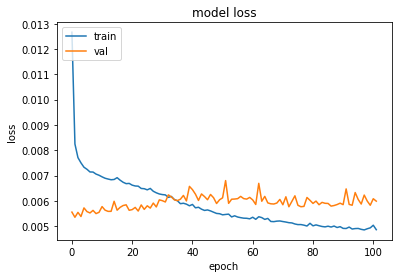

In [33]:
print("Training network:")

# Model.
model = load_model("model_Syria.h5", compile = True)

# Patient early stopping.
es = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 100)
# Fit model.
if ipython:
    history = model.fit(X_train, y_train, epochs = N_EPOCHS, validation_data = (X_val, y_val), batch_size = BATCH_SIZE, 
                        verbose = 0, shuffle = True, callbacks = [es, TqdmCallback(verbose = 1)])
else:
    history = model.fit(X_train, y_train, epochs = N_EPOCHS, validation_data = (X_val, y_val), batch_size = BATCH_SIZE, 
                        verbose = 0, shuffle = True, callbacks = [es, TQDMCallback(outer_description = "Loading:", leave_inner = False, leave_outer = False)])

# Plot result of the training and validation.
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc = "upper left")
plt.show()

# Example predict on sample

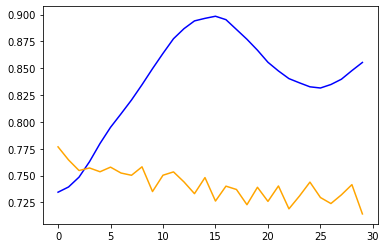

In [36]:
id_ = 40

X_test = np.expand_dims(X_train[id_], axis = 0)

pred = model.predict(X_test).flatten()
actual = y_train[id_]

# Plot the predictions.
plt.plot(actual, "blue")
plt.plot(pred, "orange");

In [32]:
from sklearn.metrics import mean_absolute_error

In [33]:
mean_absolute_error(actual, pred)

0.030583574

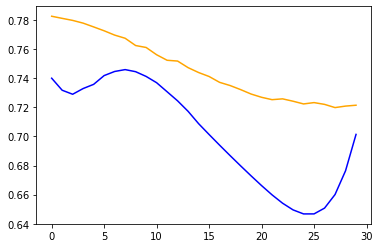

In [35]:
id_ = 3

X_test = np.expand_dims(X_val[id_], axis = 0)

pred = model.predict(X_test).flatten()
actual = y_val[id_]

# Plot the predictions.
plt.plot(actual, "blue")
plt.plot(pred, "orange");

In [61]:
mean_absolute_error(actual, pred)

0.06967251